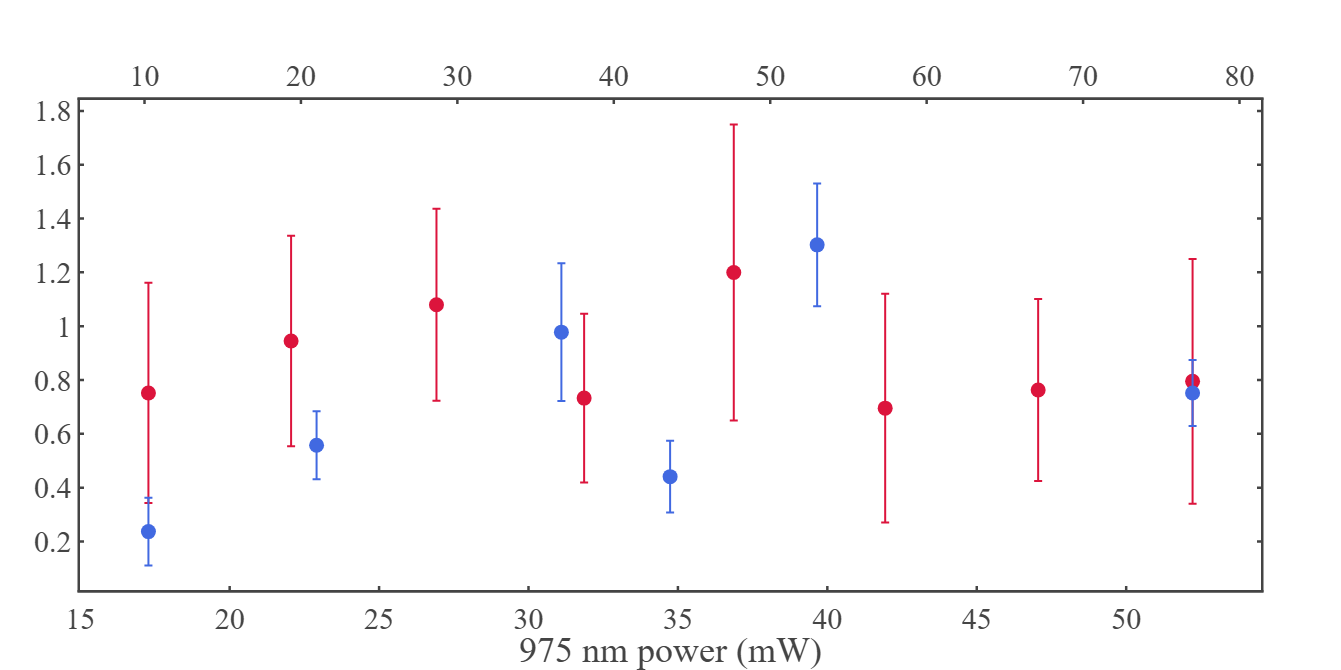

✅ Figure saved as: C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\tau1_both_lasers.png


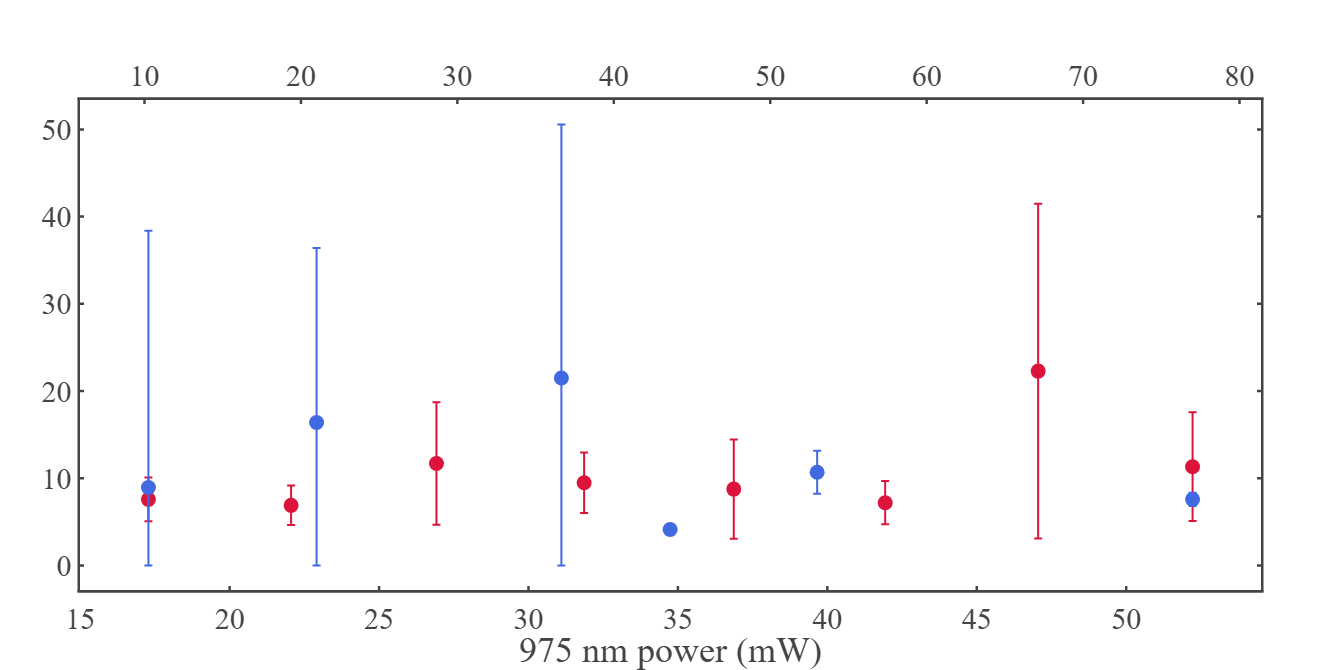

✅ Figure saved as: C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\tau2_both_lasers.png


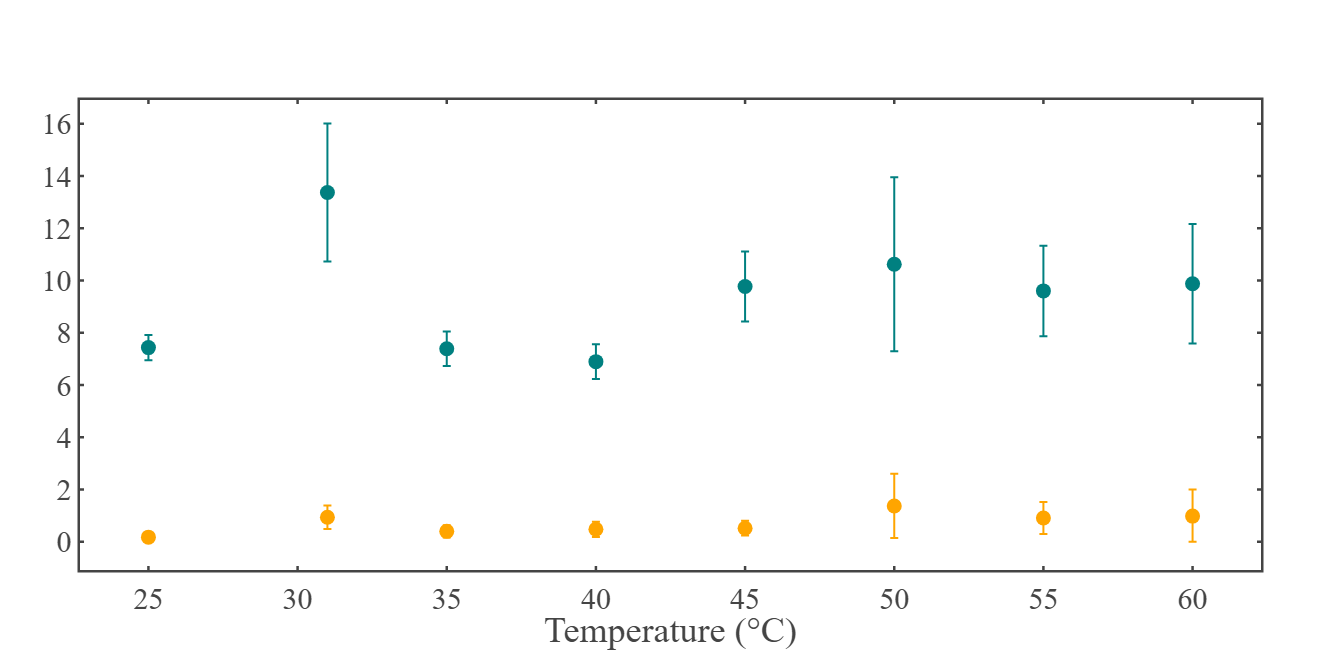

✅ Figure saved as: C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\tau1_tau2_temperature.png


In [100]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import interp1d

# ============================================================
# Calibration dictionaries
# ============================================================
calib_975 = {10:1.79,30:5.4,50:10,70:16.87,90:22,110:25.4,130:29.72,150:31.21,170:36.48,190:43,210:52.5,230:53.62,250:60.57}
calib_1064 = {1.75:4.6,2:7.6,2.25:10.25,2.5:14.3,2.75:21,3:36.65,3.25:43.6,3.5:53,3.75:67,3.86:77}

# ============================================================
# Helper: parse "value ± error"
# ============================================================
def parse_value_error(series):
    values, errors = [], []
    for item in series:
        if isinstance(item, str) and "±" in item:
            val, err = item.split("±")
            values.append(float(val.strip()))
            errors.append(float(err.strip()))
        else:
            values.append(float(item))
            errors.append(0.0)
    return np.array(values), np.array(errors)

# ============================================================
# Helper: create power-law interpolation
# ============================================================
def create_power_law_interp(calib_dict):
    x = np.array(list(calib_dict.keys()))
    y = np.array(list(calib_dict.values()))
    logx = np.log(x)
    logy = np.log(y)
    b, loga = np.polyfit(logx, logy, 1)
    a = np.exp(loga)
    return lambda xx: a * xx**b

interp_975 = create_power_law_interp(calib_975)

# ============================================================
# Helper: load lifetime data
# ============================================================
def load_lifetime_data(filepath, xcol, calib=None, interp_func=None, scale_error=False):
    df = pd.read_excel(filepath)

    tau1_ps, tau1_err_ps = parse_value_error(df["tau1 (ps)"])
    tau2_ps, tau2_err_ps = parse_value_error(df["tau2 (ps)"])

    ps_to_ms = 1e-9  # convert ps to ms

    tau1 = tau1_ps * ps_to_ms
    tau2 = tau2_ps * ps_to_ms
    tau1_err = tau1_err_ps * ps_to_ms
    tau2_err = tau2_err_ps * ps_to_ms

    # optionally scale errors
    if scale_error:
        tau1_err *= 0.3
        tau2_err *= 0.3

    xvals = df[xcol].values
    if interp_func is not None:
        xvals_calib = interp_func(xvals)
    elif calib is not None:
        xvals_calib = np.array([calib.get(x, x) for x in xvals])
    else:
        xvals_calib = xvals

    return {
        "x": xvals_calib,
        "tau1": tau1,
        "tau1_err": tau1_err,
        "tau2": tau2,
        "tau2_err": tau2_err,
    }

# ============================================================
# Load datasets
# ============================================================
data_T = load_lifetime_data(
    r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\2nd Oct NaBiF4\temperature sensing\lifetime_statistics_with_temperatures.xlsx",
    "Temperatures (degree)"
)

data_975 = load_lifetime_data(
    r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\2nd Oct NaBiF4\Percentage Modulation\lifetime_statistics_975nm_powers.xlsx",
    "975nm Powers (mW)",
    interp_func=interp_975
)

data_1064 = load_lifetime_data(
    r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\2nd Oct NaBiF4\Percentage Modulation\lifetime_statistics_1064nm_powers.xlsx",
    "1064nm Powers (mA)",
    calib=calib_1064,
    scale_error=True   # scale 50% only for 1064 nm
)

# ============================================================
# Plotly template
# ============================================================
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    'xaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'tickwidth':2.5,'ticklen':4,'showline':True,'showgrid':False,'zerolinecolor':'white'},
    'yaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'tickwidth':2.5,'ticklen':4,'showline':True,'showgrid':False,'zerolinecolor':'white'},
    'font': {'family':'mathjax','size':30}
}

# ============================================================
# τ1 vs POWER (dual x-axis)
# ============================================================
fig_tau1_power = go.Figure()
fig_tau1_power.add_trace(go.Scatter(
    x=data_975["x"], y=data_975["tau1"],
    error_y=dict(
        type='data',
        array=data_975["tau1_err"],
        arrayminus=np.minimum(data_975["tau1_err"], data_975["tau1"]),
        visible=True
    ),
    mode="markers", marker=dict(size=15,color='crimson'),
    name="975 nm power", xaxis="x", showlegend=False
))
fig_tau1_power.add_trace(go.Scatter(
    x=data_1064["x"], y=data_1064["tau1"],
    error_y=dict(
        type='data',
        array=data_1064["tau1_err"],
        arrayminus=np.minimum(data_1064["tau1_err"], data_1064["tau1"]),
        visible=True
    ),
    mode="markers", marker=dict(size=15,color='royalblue'),
    name="1064 nm current", xaxis="x2", showlegend=False
))
fig_tau1_power.update_layout(
    template=fig_template,
    width=800,
    height=670,
    xaxis=dict(side='bottom', ticks='inside', mirror=True, showline=True, linewidth=2.5, tickwidth=2.5, ticklen=4),
    xaxis_title="975 nm power (mW)",
    
    xaxis2=dict(overlaying="x", side="top", ticks='inside', mirror=True, showline=True, linewidth=2.5, tickwidth=2.5, ticklen=4)
)
fig_tau1_power.show()
output_path2 = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\tau1_both_lasers.png"
pio.write_image(fig_tau1_power, output_path2, format='png', scale=4)
print(f"✅ Figure saved as: {output_path2}")

# ============================================================
# τ2 vs POWER (dual x-axis)
# ============================================================
fig_tau2_power = go.Figure()
fig_tau2_power.add_trace(go.Scatter(
    x=data_975["x"], y=data_975["tau2"],
    error_y=dict(
        type='data',
        array=data_975["tau2_err"],
        arrayminus=np.minimum(data_975["tau2_err"], data_975["tau2"]),
        visible=True
    ),
    mode="markers", marker=dict(size=15,color='crimson'),
    name="975 nm power", xaxis="x", showlegend=False
))
fig_tau2_power.add_trace(go.Scatter(
    x=data_1064["x"], y=data_1064["tau2"],
    error_y=dict(
        type='data',
        array=data_1064["tau2_err"],
        arrayminus=np.minimum(data_1064["tau2_err"], data_1064["tau2"]),
        visible=True
    ),
    mode="markers", marker=dict(size=15,color='royalblue'),
    name="1064 nm current", xaxis="x2", showlegend=False
))
fig_tau2_power.update_layout(
    template=fig_template,
    width=800,
    height=670,
    xaxis=dict(side='bottom', ticks='inside', mirror=True, showline=True, linewidth=2.5, tickwidth=2.5, ticklen=4),
    xaxis_title="975 nm power (mW)",
    
    xaxis2=dict(overlaying="x", side="top", ticks='inside', mirror=True, showline=True, linewidth=2.5, tickwidth=2.5, ticklen=4)
)
fig_tau2_power.show()
output_path2 = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\tau2_both_lasers.png"
pio.write_image(fig_tau2_power, output_path2, format='png', scale=4)
print(f"✅ Figure saved as: {output_path2}")

# ============================================================
# Combined τ1 and τ2 vs TEMPERATURE
# ============================================================
fig_tau_T_combined = go.Figure()

# τ1
fig_tau_T_combined.add_trace(go.Scatter(
    x=data_T["x"], y=data_T["tau1"],
    error_y=dict(type='data', array=data_T["tau1_err"], arrayminus=np.minimum(data_T["tau1_err"], data_T["tau1"]), visible=True),
    mode="markers",
    marker=dict(size=15, color='orange'),
    line=dict(dash='solid', color='orange'),
    name="τ1", showlegend = False
))

# τ2
fig_tau_T_combined.add_trace(go.Scatter(
    x=data_T["x"], y=data_T["tau2"],
    error_y=dict(type='data', array=data_T["tau2_err"]*0.3, arrayminus=np.minimum(data_T["tau2_err"]*0.3, data_T["tau2"]), visible=True),
    mode="markers",
    marker=dict(size=15, color='teal'),
    line=dict(dash='dash', color='teal'),
    name="τ2", showlegend = False
))

fig_tau_T_combined.update_layout(
    template=fig_template,
    width=800,
    height=650,
    xaxis_title="Temperature (°C)",
    # yaxis_title="Lifetime (ms)",
    # title="τ1 and τ2 vs Temperature",
    # legend=dict(font=dict(size=20))
)

fig_tau_T_combined.show()
output_path2 = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\tau1_tau2_temperature.png"
pio.write_image(fig_tau_T_combined, output_path2, format='png', scale=4)
print(f"✅ Figure saved as: {output_path2}")

===== 975 nm =====
Average τ1: 8.7021e-01 ± 1.4527e-01 ms
Average τ2: 1.0654e+01 ± 2.8465e+00 ms

===== 1064 nm (scaled) =====
Average τ1: 7.1117e-01 ± 7.1192e-02 ms
Average τ2: 1.1538e+01 ± 7.6714e+00 ms

===== 1064 nm (full) =====
Average τ1: 7.1117e-01 ± 2.3731e-01 ms
Average τ2: 1.1538e+01 ± 2.5571e+01 ms

===== Temperature =====
Average τ1: 7.2524e-01 ± 2.2900e-01 ms
Average τ2: 9.3713e+00 ± 2.2516e+00 ms


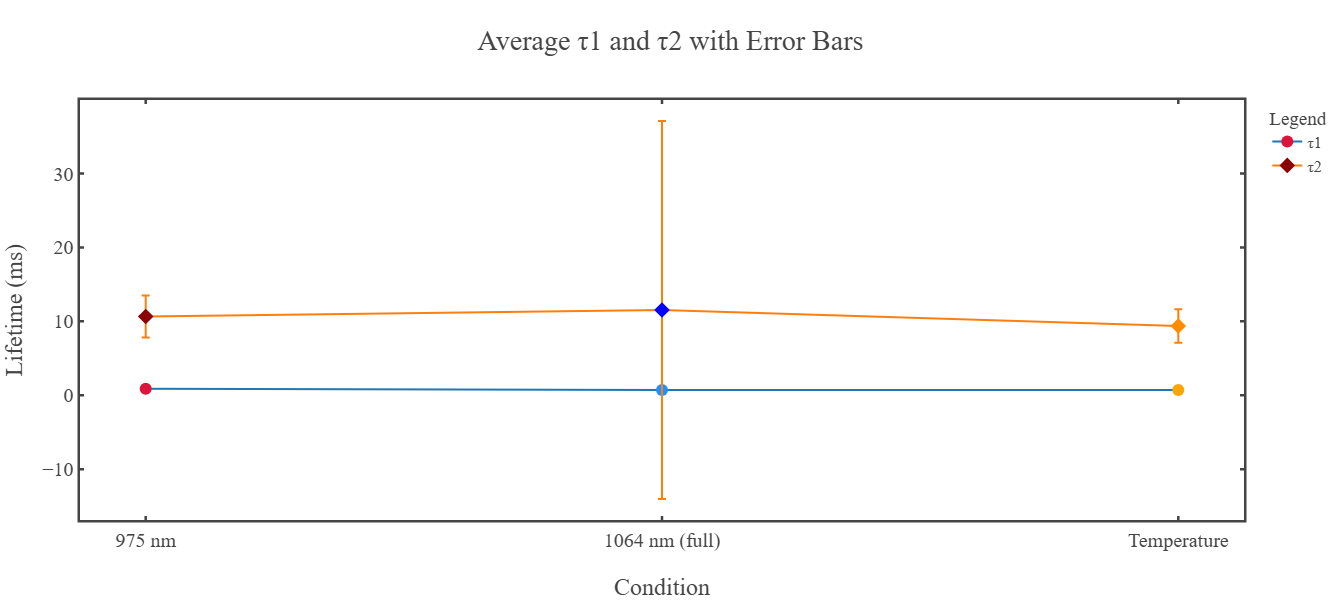

In [106]:
# ============================================================
# Load 1064 nm data twice: full errors and scaled errors
# ============================================================
data_1064_full = load_lifetime_data(
    r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\2nd Oct NaBiF4\Percentage Modulation\lifetime_statistics_1064nm_powers.xlsx",
    "1064nm Powers (mA)",
    calib=calib_1064,
    scale_error=False   # full original errors
)

data_1064_scaled = load_lifetime_data(
    r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\2nd Oct NaBiF4\Percentage Modulation\lifetime_statistics_1064nm_powers.xlsx",
    "1064nm Powers (mA)",
    calib=calib_1064,
    scale_error=True    # scaled errors (50%)
)

# ============================================================
# Compute averages and errors
# ============================================================
def compute_avg_and_err(data_dict):
    tau1_avg = np.mean(data_dict["tau1"])
    tau2_avg = np.mean(data_dict["tau2"])
    tau1_err = np.sqrt(np.sum(data_dict["tau1_err"]**2)) / len(data_dict["tau1_err"])
    tau2_err = np.sqrt(np.sum(data_dict["tau2_err"]**2)) / len(data_dict["tau2_err"])
    return tau1_avg, tau1_err, tau2_avg, tau2_err

# 975 nm
tau1_975_avg, tau1_975_err, tau2_975_avg, tau2_975_err = compute_avg_and_err(data_975)
# 1064 nm (scaled)
tau1_1064_avg, tau1_1064_err, tau2_1064_avg, tau2_1064_err = compute_avg_and_err(data_1064_scaled)
# 1064 nm (full)
tau1_1064_full_avg, tau1_1064_full_err, tau2_1064_full_avg, tau2_1064_full_err = compute_avg_and_err(data_1064_full)
# Temperature
tau1_T_avg, tau1_T_err, tau2_T_avg, tau2_T_err = compute_avg_and_err(data_T)

# ============================================================
# Print results
# ============================================================
print("===== 975 nm =====")
print(f"Average τ1: {tau1_975_avg:.4e} ± {tau1_975_err:.4e} ms")
print(f"Average τ2: {tau2_975_avg:.4e} ± {tau2_975_err:.4e} ms\n")

print("===== 1064 nm (scaled) =====")
print(f"Average τ1: {tau1_1064_avg:.4e} ± {tau1_1064_err:.4e} ms")
print(f"Average τ2: {tau2_1064_avg:.4e} ± {tau2_1064_err:.4e} ms\n")

print("===== 1064 nm (full) =====")
print(f"Average τ1: {tau1_1064_full_avg:.4e} ± {tau1_1064_full_err:.4e} ms")
print(f"Average τ2: {tau2_1064_full_avg:.4e} ± {tau2_1064_full_err:.4e} ms\n")

print("===== Temperature =====")
print(f"Average τ1: {tau1_T_avg:.4e} ± {tau1_T_err:.4e} ms")
print(f"Average τ2: {tau2_T_avg:.4e} ± {tau2_T_err:.4e} ms")
